Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/05/08


In [13]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from scipy import stats, integrate
from sklearn.feature_selection import VarianceThreshold
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import neighbors
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Software Bug Prediction through metrics 


## Question:

Can the Chidamber & Kemerer software metrics be used to accurately predict the number of bugs in software? 


### Data:

Data comes from the Bug prediction dataset repository website [2].
The website houses a section of CK metrics for a number software projects. For each of the 5 projects there is 8 CSV files containing CK software metrics computed for each class definition within the project.   All metrics hosted at the website where harvested from projects programed in the Java programming language.

All Four projects' data was used. All of the project metrics was collected from the Apache Software Foundation. The metric data was concatenated from the 5 files into a single CSV file for easier manipulation.  

The 4 projects are;
1. Eclipse JDT
2. Eclipse PDE
3. Equinox Framework
4. Lucene
5. Myylyn


The above data can [be found at](http://bug.inf.usi.ch/download.php). 


### Context:

Computers are ubiquitous. In everything from house appliances to motor vehicles.  The software run on these computers has become extremely complex and large. Tasked with controlling driverless cars to flying multiple drones simultaneously. With this increased software complexity comes higher rates of software bugs.  Many bugs do not get identified and corrected before the software is released. The cost of correcting a software bug increases as the defect passes through the later phases of the Software Development life cycle [4]. 

Machine learning can help identify which pieces of software have higher rates of defects thus allowing teams to focus their testing resources on those portions of the software. Therefore, reducing costs. In addition, defect prediction  can be used address short comings in design that can be used to address later projects. 


### Content:

The Chidamber and Kemerer (C&K) Metrics were designed to assess the quality of Object Oriented programming languages [1].  The metrics were first proposed in 1994 when the only commercially significant Object-Oriented languages were Smalltalk and C++. Chidamber and Kemerer used a two commercial applications (one in C++ and one in Smalltalk) to assess the validity of their metrics.

Although measuring the amount of reuse a code base contains is frequently mentioned this was not the initial aim of of the metrics. They had read Grady Booch's 'Object Oriented Design with Applications' and were looking for a set of metrics that would assist this design approach. The idea was that the metrics would allow a designer to compare one potential design against another and predict which would be better. This meant that the metrics would have to be capable of being based on a design rather than code. Another interesting point was that C&K firmly believed in a practical commercial approach stating '0bject Oriented design metrics should offer needed insights into whether developers are following 00 principles in their designs.

The metrics after the separator are a separate set of Object Oriented metrics that were selected by the authors who harvest the metric data for the original study [3].

 + Weighted Methods per Class - The value of the WMC is equal to the total Cyclomatic Complexity of all methods with in a class.


+ Depth of Inheritance Tree - The number of class definitions from the top of the class hierarchy to the leaf.


+ Number of Children - The number of immediate descendants of the class under question.


+ Coupling between objects - Represents the number of classes coupled to a given class (efferent  couplings  and  afferent  couplings). These  couplings  can  occur  through  method  calls and attribute access.


+ Response for a Class - Measures the number of different methods that can be executed when an instance of that class has an interface method invoked. Transitive closure of the method call graph.


+ Lack of Cohesion in Methods - Counts the sets of methods in a class that are not related through the sharing of some of the class attributes. Attempts to measure of how well the methods of the class co-operate to achieve the aims of the class.


+ Afferent couplings - The number of classes that depend upon the measured class (Fan In). 


+ Efferent couplings - The number of classes that the measured class is depended upon (Fan Out).

============================================================================================================

+ Number of Public Methods - The methods in a class that are declared as public. The metric is known also as Class Interface Size (CIS).


+ Number of Attributes - The total number of attributes defined for a class.


+ Number of public attributes - The number of class attributes that have an access modifier of public.


+ Number of private attributes - The number of class attributes that have an access modifier of private.


+ Lines of Code - The number of lines of code in the Java binary code of the class under investigation.


+ Number of attributes inherited - This total number of inherited attributes from parents of a class.


+ Number of methods - The total number of methods defined within a class.


+ Number of methods inherited - Measures the total number of methods that are inherited from parent and or interface classes.


+ Number of private methods - The number of class methods that have an access modifier of private.


+ Number of Bugs - Gleamed from source code repository logs that linked a fix for an issue reported in the bug tracking system (Jira/Bugzilla).

In [2]:
# Read CSV containing software metrics data
data_file = '/media/ianh/space/ThinkfulData/PredictingSoftwareBugs/transformed_full-ambrose-metrics-ck-oo.csv'
sw_metrics = pd.read_csv(data_file)
print("\nObservations : %d\nFeatures : %d" % (sw_metrics.shape[0], sw_metrics.shape[1]))

# Remove the classname feature. This is the name of the source code file that the metrics pertain to.
del sw_metrics['classname']


Observations : 5371
Features : 20


## Preprocessing and exploratory data analysis

The software metrics dataset has been read from a CSV that has already had a far amount of exploratory data analysis and preprocessing carried out.  The notebook housing these steps can be found [here](https://github.com/315iah515/Thinkful-Notebooks/blob/master/Bootcamp/Supervised/CapStone/SupervisedCapstoneExploratory.ipynb).

This has been done for brevity.  All features have been standardized except for for the target variable.  Standardization of the features offers a number of advantages.  First, all metrics now have the same scale and can be easily compared.  Secondly, decision trees and random forests are one of the very few machine learning algorithms that do not require feature scaling and due to the nature of the question we hope to answer it is likely that some form of Regression model will be employed.

All features are discrete in nature. Most features have a exponential distribution with positive outliers.  Some features have a geometric distribution.  These descriptions apply to the original state of the data before transformation. Please see the link above for more detail. 

None of the features have a normal distribution. Ten of the features have been transformed using the BoxCox transformation. 

$$y^i=\frac{\lambda^y - 1}{\lambda}$$

Due to the large number of zero values for metrics a positive constant was added to a metric value before the transformation was invoked. Six of the features' distributions have a right skewness and were altered using a cube root transformation. A cube root transformation was also applied to the dependent variable so that an association between the features was still present after the transformation of the independent variables. 


## Feature Selection

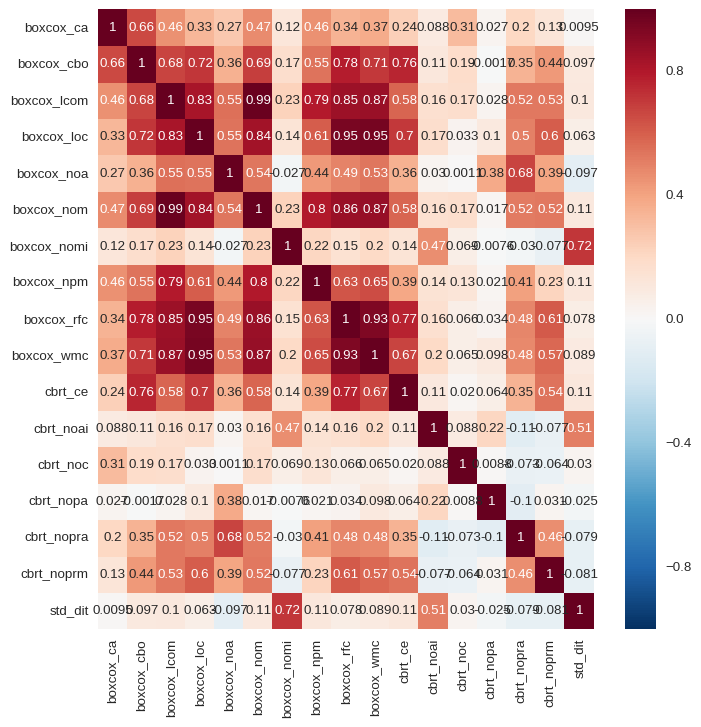

In [25]:
exclude = ['bugs', 'cbrt_bugs']
corr = sw_metrics.ix[:, sw_metrics.columns.difference(exclude)].corr()
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__  = sb.heatmap(corr, annot=True)

There is quite a bit of multicollinearity between the features. Considering the sparseness of the number of bugs to the total number of defects within the dataset we will not perform any feature combining or principle component analysis. There is useful variance between the features that we would like to tease out.  Models that can perform similarly to PCA or models that do not require low multicollinearity will be employed.  

Many of these positive associations between features make sense. 
Response for a class and Lines of Code are highly correlated.  The former measures the number of different methods invoked when the interface of the class has one of its methods called.  The larger the call graph the more lines of code that the class presumably contains.  

Another set of correlated features are Lack of Cohesion in Methods and Weighted Method Count(WMC). WMC is just the total number of methods contained within a class definition. Where each method is weighted by its Cyclometric Complexity. Cyclometric Complexity is the quantitative measure of the number of linearly independent paths through a program's source.  Doubtless that WMC is attempting to measure the amount of effort and/or time needed to develop and maintain the class. Low values are considered better. 

If many methods can be invoked in response to a client’s use of the class interface then testing and debugging of the class becomes more complicated and much harder to manage.  It is easy to image that a large call graph derived from RFC would correlate to WMC.  


Accuracy on training set: 0.844

Accuracy on test set: 0.823
F1 score :
 [ 0.89495024  0.44227006]


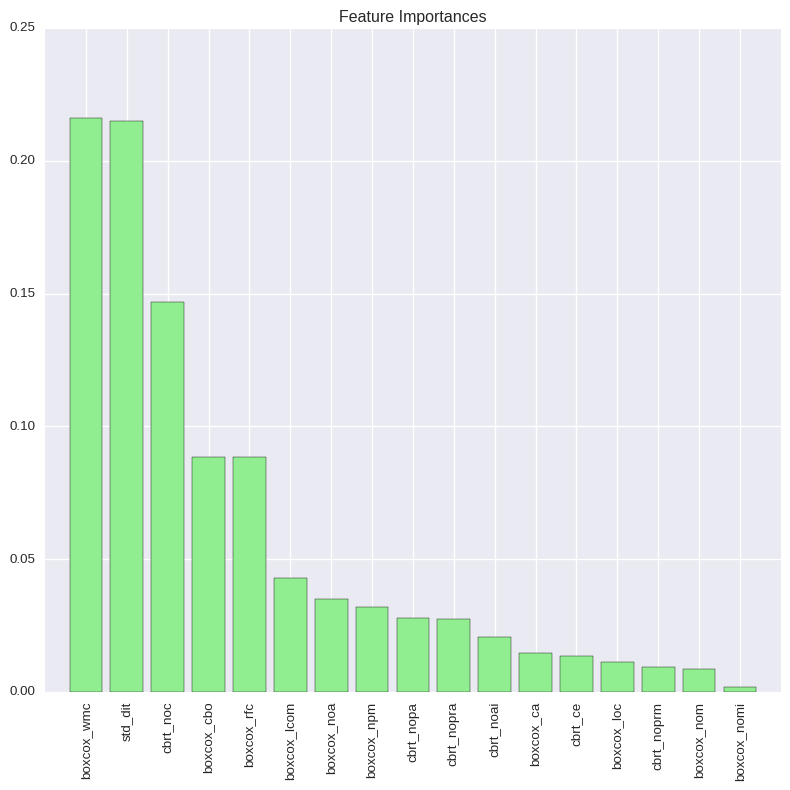

In [5]:
# Feature selection with Random Forest
from sklearn.metrics import f1_score

sw_metrics['bugs_b'] = np.where(sw_metrics.bugs > 0, 1, 0)
y = sw_metrics.bugs_b
X = sw_metrics.drop(['bugs', 'bugs_b', 'cbrt_bugs'], axis=1)

labels = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=4, class_weight={0:1, 1:3})
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightgreen', align='center')
plt.xticks(range(X_train.shape[1]), labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))

y_ = rfc.predict(X_test)

print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))
print("F1 score :\n %s" % (f1_score(y_test, y_, average=None)))

## Models

### Baseline Model
Our first step in model selection is the creation of Baseline Model which all models must improve upon.  The average number of bugs in the dataset is 0.260.  Each model when feed test data, derived from all observations, must at a minimum produce a performace metric better than the average.

### Partial Least Squares Regression

There is a high level of multicollinearity between the features. This is especially the case for those features that incorporate the number of methods, complexity, and lines of code.  Obviously, the more methods a class declaration has the more lines of code are present.

PCA was not performed as this would remove the interpretability of which features are better at predicting the number of bugs.  Although number of independent variables is not significantly larger than the number of data points for this dataset there is multicollinearity between the features. 

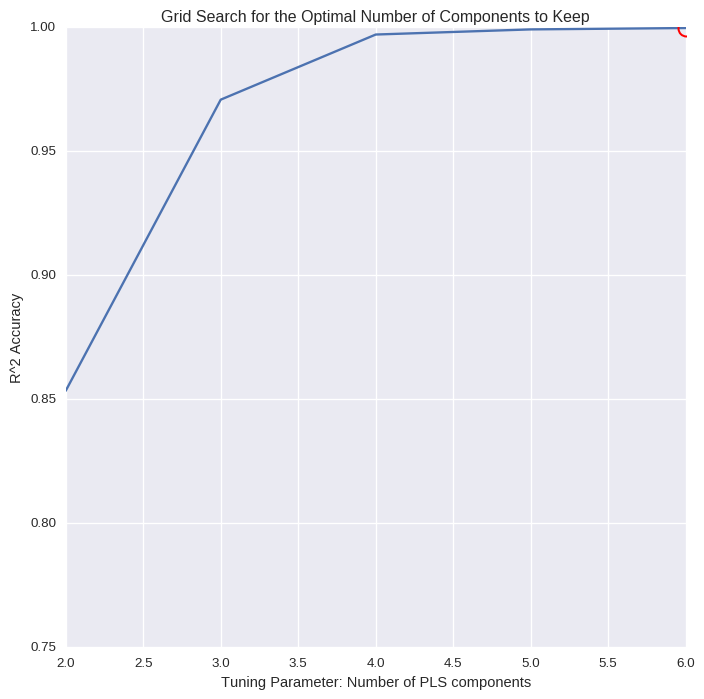

In [43]:
components_range = list(range(2, 7))
param_grid = dict(n_components=components_range)

pls = PLSRegression(n_components=3, scale=False)
grid = GridSearchCV(pls, param_grid, cv=5)
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['bugs','bugs_b'], axis=1)
grid.fit(X, y)

# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.75, 1.0])
plt.xlabel('Tuning Parameter: Number of PLS components')
plt.ylabel('R^2 Accuracy')
plt.plot(components_range, grid_mean_scores)
plt.title('Grid Search for the Optimal Number of Components to Keep')
__ = plt.plot(grid.best_params_['n_components'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

We search for the best number of components to keep when running the PLS model. 

In [20]:
mean_bugs = sw_metrics.bugs.mean()
print('Mean number of bugs in dataset: %.3f' % (mean_bugs))
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['bugs','bugs_b'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
pls = PLSRegression(n_components=4, scale=False)
pls.fit(X_train, y_train)
y_ = pls.predict(X_train)


print("\nAccuracy on training set: {:.3f}".format(pls.score(X_train, y_train)))
print('PLS RMSE of training set: %.3f\n' % (np.sqrt(metrics.mean_squared_error(y_train, y_))) )

print("\nAccuracy on test set: {:.3f}".format(pls.score(X_test, y_test)))
y_ = pls.predict(X_test)

print('PLS RMSE of test set: %.3f' % (np.sqrt(metrics.mean_squared_error(y_test, y_))) )
cbrt_mean_bugs = (np.cbrt(mean_bugs) * np.ones_like(y_test))
#mean_bugs = (mean_bugs * np.ones_like(y_test))

# convert back to original form
baseline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, cbrt_mean_bugs))
print('\nBaseline RMSE of test set: %.3f' % (baseline_RMSE) ) 
print('Baseline RMSE converted to original scale: %.3f' % (baseline_RMSE**3))

Mean number of bugs in dataset: 0.260

Accuracy on training set: 0.997
PLS RMSE of training set: 0.035


Accuracy on test set: 0.997
PLS RMSE of test set: 0.035

Baseline RMSE of test set: 1.220
Baseline RMSE converted to original scale: 1.816


### Conclusion 

### Nearest Neighbors Regression

Nearest Neighbors Regression makes no assumption about the normality of the features or that there is a low level of multicollinearity.  More importantly, there is no assumption of linearity between the features and the target variable.   First, we run grid search to find the best number of neighbors and then run the model with the select number of neighbors. 

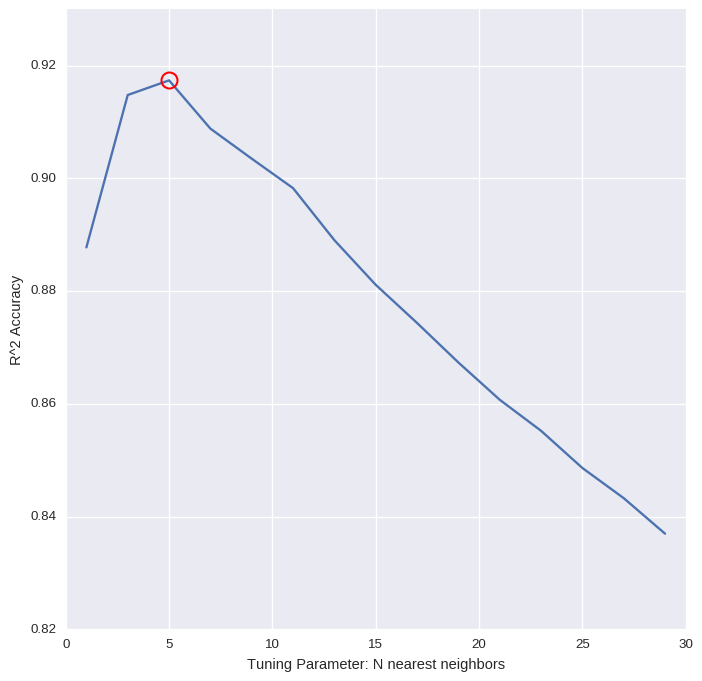

In [9]:
# Let us find the best value for k
knr = neighbors.KNeighborsRegressor(weights='distance')

k_range = list(range(1, 30, 2))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knr, param_grid, cv=5)
y = sw_metrics.cbrt_bugs
X = sw_metrics.drop(['bugs','bugs_b'], axis=1)
grid.fit(X, y)


# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.82, 0.93])
plt.xlabel('Tuning Parameter: N nearest neighbors')
plt.ylabel('R^2 Accuracy')
plt.plot(k_range, grid_mean_scores)
__ = plt.plot(grid.best_params_['n_neighbors'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

The optimal value for the number of neighbors for the software metrics data is 5.  We now fit the KNR model with the data using the value and see if it performs better than our baseline model. 

In [42]:
print('Mean number of bugs in dataset: %.3f' % (mean_bugs))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
knr = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knr.fit(X_train, y_train)
y_ = knr.predict(X_train)


print("\nAccuracy on training set: {:.3f}".format(knr.score(X_train, y_train)))
print('KNR RMSE of training set: %.3f\n' % (np.sqrt(metrics.mean_squared_error(y_train, y_))) )

print("\nAccuracy on test set: {:.3f}".format(knr.score(X_test, y_test)))
y_ = knr.predict(X_test)

print('KNR RMSE of test set: %.3f' % (np.sqrt(metrics.mean_squared_error(y_test, y_))) )
cbrt_mean_bugs = (np.cbrt(mean_bugs) * np.ones_like(y_test))
#mean_bugs = (mean_bugs * np.ones_like(y_test))

# convert back to original form
baseline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, cbrt_mean_bugs))
print('\nBaseline RMSE of test set: %.3f' % (baseline_RMSE) ) 
print('Baseline RMSE converted to original scale: %.3f' % (baseline_RMSE**3))

Mean number of bugs in dataset: 0.260

Accuracy on training set: 1.000
KNR RMSE of training set: 0.000


Accuracy on test set: 0.734
KNR RMSE of test set: 0.561

Baseline RMSE of test set: 1.144
Baseline RMSE converted to original scale: 1.496


### Conclusion 

### Gradient Boosting regression

One of its major advantages of Gardient Boosting is that the model handles mixed data types, and it is also quite robust to outliers. The metrics dataset has several outliers. These outliers are reasonable considering the context. There is bad and good software. And there is some pretty bad software out there.

We run grid search to find the best maximum depth of the trees limiting he total number of nodes within the binary tree. For the target variable, we will use the untransformed bug feature.   There is no need to enforce a linear relationship between the independent variables for this model.  This will make are comparison with our base model a little easier. 

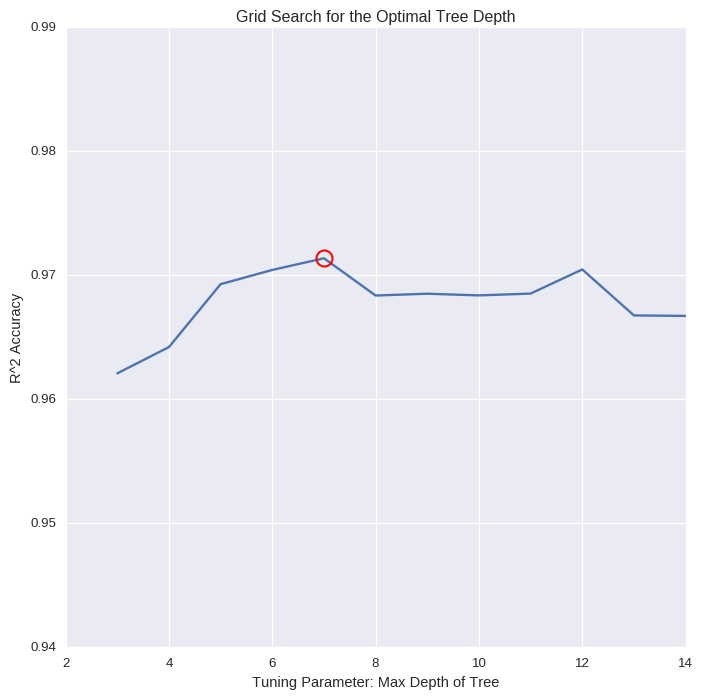

In [40]:
# Let us find the best value for depth of tree
gbr = ensemble.GradientBoostingRegressor()

max_depth_range = list(range(3, 15))
param_grid = dict(max_depth=max_depth_range)

grid = GridSearchCV(gbr, param_grid, cv=5)
y = sw_metrics.bugs
X = sw_metrics.drop(['cbrt_bugs','bugs_b'], axis=1)
grid.fit(X, y)

# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.94, 0.99])
plt.xlabel('Tuning Parameter: Max Depth of Tree')
plt.ylabel('R^2 Accuracy')
plt.plot(max_depth_range, grid_mean_scores)
plt.title('Grid Search for the Optimal Tree Depth')
__ = plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

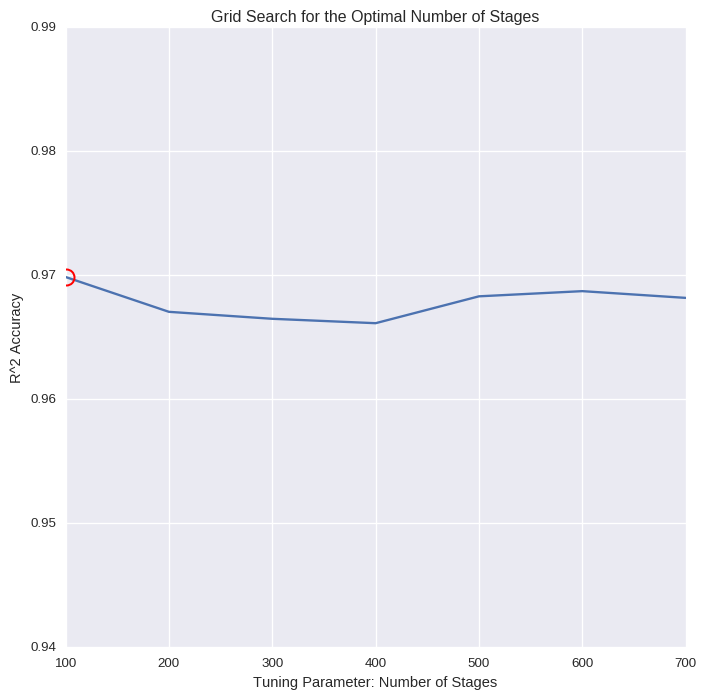

In [41]:
# Let us find the best value for the number of stages to run
gbr = ensemble.GradientBoostingRegressor()

estimators_range = list(range(100, 800, 100))
param_grid = dict(n_estimators=estimators_range)

grid = GridSearchCV(gbr, param_grid, cv=5)
y = sw_metrics.bugs
X = sw_metrics.drop(['cbrt_bugs','bugs_b'], axis=1)
grid.fit(X, y)


# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.94, 0.99])
plt.xlabel('Tuning Parameter: Number of Stages')
plt.ylabel('R^2 Accuracy')
plt.plot(estimators_range, grid_mean_scores)
plt.title('Grid Search for the Optimal Number of Stages')
__ = plt.plot(grid.best_params_['n_estimators'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

In [44]:
print('Mean number of bugs in dataset: %.3f' % (mean_bugs))

# We are using the untransformed bug feature defined above.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
gbr = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=100)
gbr.fit(X_train, y_train)
y_ = gbr.predict(X_train)


print("\nAccuracy on training set: {:.3f}".format(gbr.score(X_train, y_train)))
print('KNR RMSE of training set: %.3f\n' % (np.sqrt(metrics.mean_squared_error(y_train, y_))) )

print("\nAccuracy on test set: {:.3f}".format(gbr.score(X_test, y_test)))
y_ = gbr.predict(X_test)

print('KNR RMSE of test set: %.3f' % (np.sqrt(metrics.mean_squared_error(y_test, y_))) )
#cbrt_mean_bugs = (np.cbrt(mean_bugs) * np.ones_like(y_test))
mean_bugs = (mean_bugs * np.ones_like(y_test))

# Lets compute how well the model compares to baseline
baseline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, mean_bugs))
print('\nBaseline RMSE of test set: %.3f' % (baseline_RMSE) ) 

Mean number of bugs in dataset: 0.260

Accuracy on training set: 1.000
KNR RMSE of training set: 0.000


Accuracy on test set: 0.998
KNR RMSE of test set: 0.028

Baseline RMSE of test set: 0.924


### Feature Importance

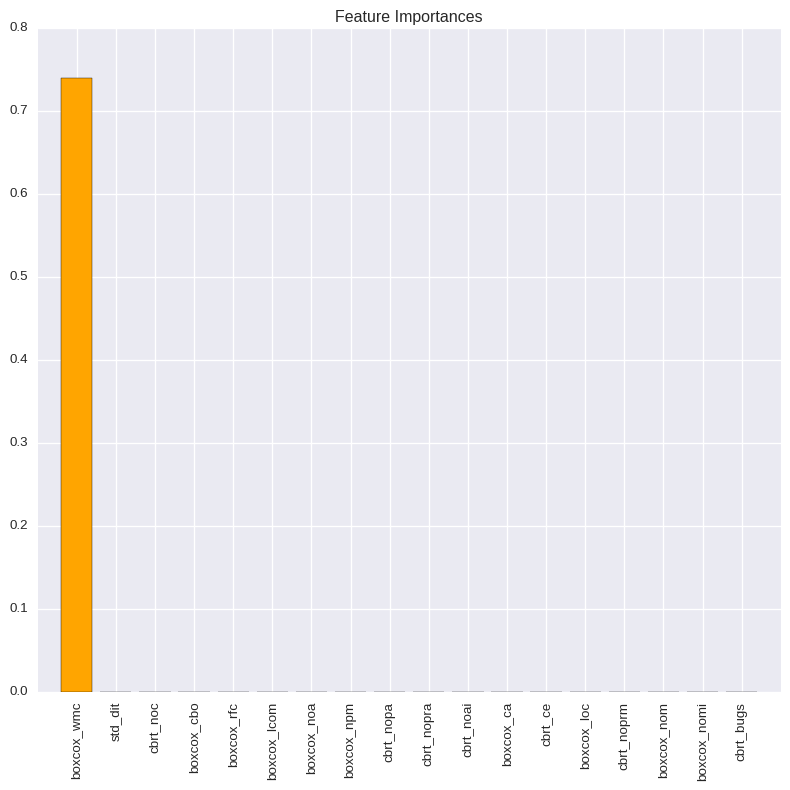

In [49]:
labels = X.columns
importances = gbr.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='orange', align='center')
plt.xticks(range(X_train.shape[1]), labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

### Conclusion 

## Discussion 

## References

1. Chidamber, S.R.; Kemerer, C.F. IEEE Transactions on Software Engineering Volume 20, Issue 6, Jun 1994 Page(s):476 - 493
2. http://bug.inf.usi.ch/index.php
3. An Extensive Comparison of Bug Prediction Approaches Marco D'Ambros, Michele Lanza, Romain Robbes, In Proceedings of MSR 2010 (7th IEEE Working Conference on Mining Software Repositories), pp. 31 - 41. IEEE CS Press, 2010.
4. Cigital, "Case study: Finding defects earlier yields enormous savings," Available at www.cigital.com, 2003

